In [110]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')

In [111]:
df = pd.read_csv('heart_cleaned.csv')
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289.0,0,172,0,0.0,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180.0,0,156,0,1.0,True,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283.0,0,98,0,0.0,False,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,0,138,214.0,0,108,1,1.5,True,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,1,150,195.0,0,122,0,0.0,False,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [112]:
class FeatureCategorizer:
    def __init__(self, df):
        self.df = df.copy()
        self.continuous_features = []
        self.binary_features = []
        
    def categorize_features(self):
        
        for col in self.df.columns:
            unique_vals = self.df[col].nunique()
            is_numeric = pd.api.types.is_numeric_dtype(self.df[col])
            unique_values = sorted(self.df[col].unique())

            if is_numeric:
                if unique_vals == 2 or set(self.df[col].unique()).issubset({0, 1, 0.0, 1.0}):
                    self.binary_features.append(col)
                else:
                    self.continuous_features.append(col)
            else:
                # Handle boolean or string binary features
                if unique_vals == 2:
                    self.binary_features.append(col)
                else:
                    print(f"  → Classified as: OTHER (will be ignored)")
        return self.continuous_features, self.binary_features
# Categorize features
categorizer = FeatureCategorizer(df)
continuous_features, binary_features = categorizer.categorize_features()


In [113]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']

mutua_informazione_feature = []

def analyze_feature_information(X, Y, continuous_features, binary_features):
    """
    Calcola la mutual information media per feature numeriche e binarie.
    
    Args:
        X (pd.DataFrame): dataset delle feature
        y (pd.Series o array): target
        numerical_features (list): lista nomi delle feature numeriche
        binary_features (list): lista nomi delle feature binarie
    
    Returns:
        dict: valori medi di mutual information
    """
    # Calcolo mutual information per tutte le feature
    mi = mutual_info_classif(X, Y, discrete_features='auto', random_state=42)
    mi_df = pd.DataFrame({
        "feature": X.columns,
        "mutual_info": mi
    })
    
    # Separazione numeriche e binarie
    mi_numerical = mi_df[mi_df["feature"].isin(continuous_features)]["mutual_info"].mean()
    mi_binary = mi_df[mi_df["feature"].isin(binary_features)]["mutual_info"].mean()
    
    return {
        "MI_numerical": mi_numerical,
        "MI_binary": mi_binary
    }

ris = analyze_feature_information(X, Y, continuous_features, binary_features)
print(ris)

{'MI_numerical': np.float64(0.06646737346489448), 'MI_binary': np.float64(0.06725815612608918)}


In [114]:
def add_progressive_noise(df: pd.DataFrame, target_column: str) -> dict:
    """
    Aggiunge progressivamente rumore a una colonna target binaria (0/1) di un DataFrame.

    La funzione itera dal 0% al 100% con incrementi del 10%, e per ogni step
    inverte una percentuale corrispondente di etichette nella colonna target.

    Args:
        df (pd.DataFrame): Il DataFrame di input.
        target_column (str): Il nome della colonna target binaria da modificare.

    Returns:
        dict: Un dizionario di DataFrame. Le chiavi indicano la percentuale
              di rumore e i valori sono i DataFrame modificati.
    """
    # Controlla che la colonna target sia binaria (contenente solo 0 e 1)
    if not all(df[target_column].isin([0, 1])):
        raise ValueError(f"La colonna '{target_column}' non è binaria (deve contenere solo 0 e 1).")

    noisy_datasets = {}
    n_samples = len(df)
    
    print(f"DataFrame originale con {n_samples} righe.")

    # Itera attraverso le percentuali di rumore da 0 a 100 con step di 10
    for percentage in range(0, 101, 10):
        # Lavoriamo sempre su una copia pulita del df originale per evitare rumore cumulativo
        df_noisy = df.copy()
        
        # Se la percentuale è 0, non facciamo nulla e salviamo la copia originale
        if percentage == 0:
            noisy_datasets[f'0%_noise'] = df_noisy
            continue

        # Calcola il numero di etichette da "flippare" (invertire)
        n_to_flip = int(np.floor(n_samples * (percentage / 100)))

        # Seleziona casualmente gli indici delle righe da modificare
        # Usiamo random_state per la riproducibilità degli esperimenti
        indices_to_flip = df.sample(n=n_to_flip, random_state=42).index

        # Inverti i valori nella colonna target per gli indici selezionati
        # Questo trucco (1 - valore) funziona perfettamente per etichette binarie 0/1
        df_noisy.loc[indices_to_flip, target_column] = ~df_noisy.loc[indices_to_flip, target_column]
        
        # Salva il DataFrame rumoroso nel dizionario
        key_name = f'{percentage}%_noise'
        noisy_datasets[key_name] = df_noisy
        print(f"Generato dataset con {percentage}% di rumore ({n_to_flip} etichette invertite).")

    return noisy_datasets


In [115]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

all_metrics_noisy = []

def calculate_metrics(y_test, y_pred, model_name, approach, step_idx):
    """
    Calculate metrics and return a dictionary with model info
    """
    metrics = {
        'model': model_name,
        'approach': approach,
        'step': step_idx,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    # Print metrics (to maintain your current output format)
    print(f"Misure di performance globali {model_name.lower()} {approach.lower()}\n")
    print('Accuracy:', metrics['accuracy'])
    print('Precision:', metrics['precision'])
    print('Recall:', metrics['recall'])
    print('F1-score:', metrics['f1_score'])
    
    return metrics

timing_collector_noisy= {
    'dt_naive_training': 0,
    'dt_optimal_training': 0, 
    'dt_hyperparameter': 0,
    'svm_naive_training': 0,
    'svm_optimal_training': 0,
    'svm_hyperparameter': 0,
    'nn_naive_training': 0,
    'nn_optimal_training': 0,
    'nn_hyperparameter': 0
}

DataFrame originale con 918 righe.
Generato dataset con 10% di rumore (91 etichette invertite).
Generato dataset con 20% di rumore (183 etichette invertite).
Generato dataset con 30% di rumore (275 etichette invertite).
Generato dataset con 40% di rumore (367 etichette invertite).
Generato dataset con 50% di rumore (459 etichette invertite).
Generato dataset con 60% di rumore (550 etichette invertite).
Generato dataset con 70% di rumore (642 etichette invertite).
Generato dataset con 80% di rumore (734 etichette invertite).
Generato dataset con 90% di rumore (826 etichette invertite).
Generato dataset con 100% di rumore (918 etichette invertite).


--- INIZIO TRAINING: DECISION TREE ---

===== Training Decision Tree (Naive) with 0% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.7391304347826086
Precision: 0.8241758241758241
Recall: 0.7009345794392523
F1-score: 0.7575757575757576
Noise 0% - Decision Tree (Naive)
  Accuracy Test:   0.7391 (valutato su dati pul

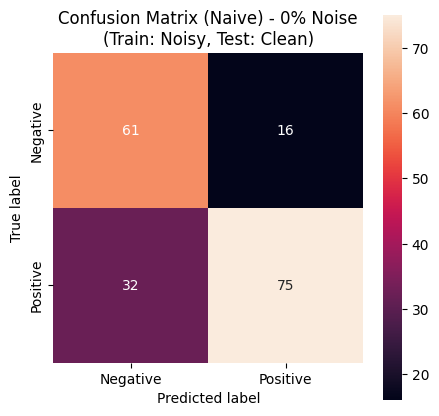

✅ Step 0% completed


===== Training Decision Tree (Naive) with 10% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.717391304347826
Precision: 0.7570093457943925
Recall: 0.7570093457943925
F1-score: 0.7570093457943925
Noise 10% - Decision Tree (Naive)
  Accuracy Test:   0.7174 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0025 sec


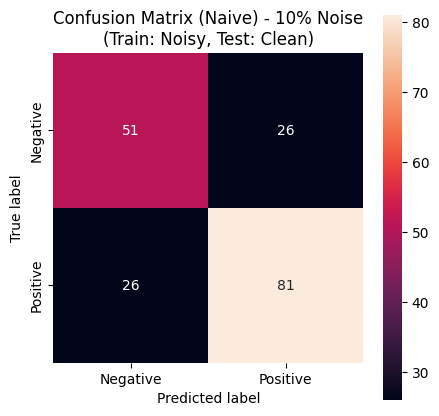

✅ Step 10% completed


===== Training Decision Tree (Naive) with 20% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.6413043478260869
Precision: 0.7157894736842105
Recall: 0.6355140186915887
F1-score: 0.6732673267326733
Noise 20% - Decision Tree (Naive)
  Accuracy Test:   0.6413 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0028 sec


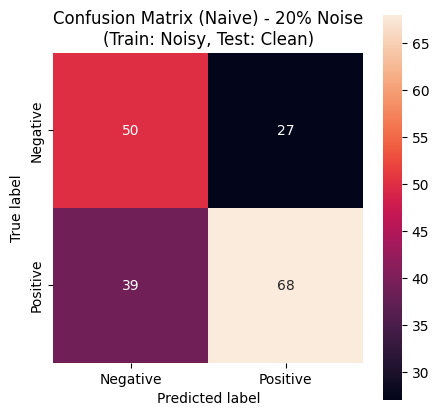

✅ Step 20% completed


===== Training Decision Tree (Naive) with 30% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.625
Precision: 0.7317073170731707
Recall: 0.5607476635514018
F1-score: 0.6349206349206349
Noise 30% - Decision Tree (Naive)
  Accuracy Test:   0.6250 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0038 sec


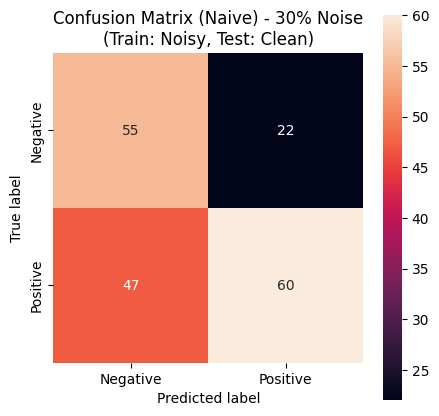

✅ Step 30% completed


===== Training Decision Tree (Naive) with 40% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.5434782608695652
Precision: 0.6493506493506493
Recall: 0.4672897196261682
F1-score: 0.5434782608695652
Noise 40% - Decision Tree (Naive)
  Accuracy Test:   0.5435 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0037 sec


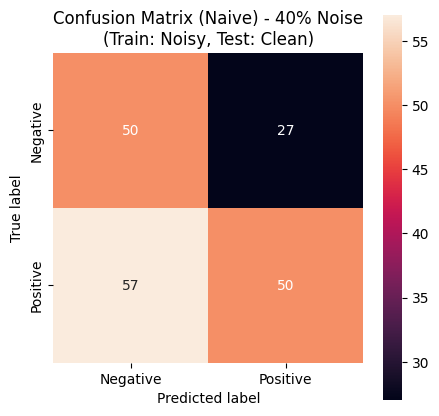

✅ Step 40% completed


===== Training Decision Tree (Naive) with 50% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.5380434782608695
Precision: 0.627906976744186
Recall: 0.5046728971962616
F1-score: 0.5595854922279793
Noise 50% - Decision Tree (Naive)
  Accuracy Test:   0.5380 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0041 sec


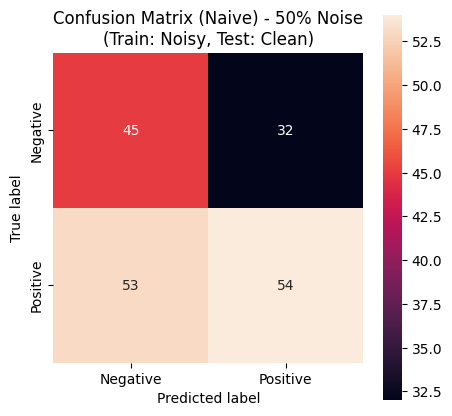

✅ Step 50% completed


===== Training Decision Tree (Naive) with 60% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.41847826086956524
Precision: 0.5
Recall: 0.37383177570093457
F1-score: 0.42780748663101603
Noise 60% - Decision Tree (Naive)
  Accuracy Test:   0.4185 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0033 sec


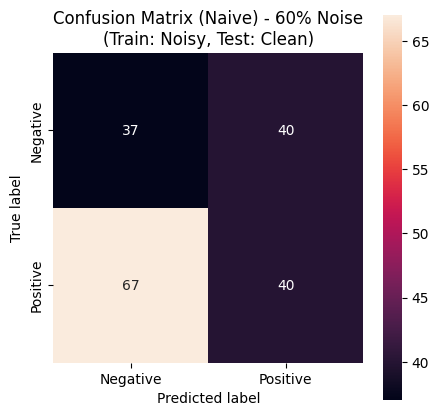

✅ Step 60% completed


===== Training Decision Tree (Naive) with 70% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.42391304347826086
Precision: 0.5063291139240507
Recall: 0.37383177570093457
F1-score: 0.43010752688172044
Noise 70% - Decision Tree (Naive)
  Accuracy Test:   0.4239 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0031 sec


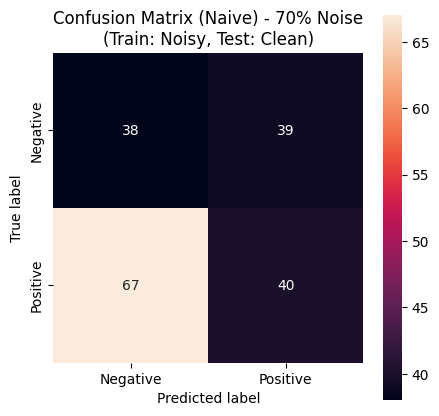

✅ Step 70% completed


===== Training Decision Tree (Naive) with 80% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.32608695652173914
Precision: 0.3924050632911392
Recall: 0.2897196261682243
F1-score: 0.3333333333333333
Noise 80% - Decision Tree (Naive)
  Accuracy Test:   0.3261 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0030 sec


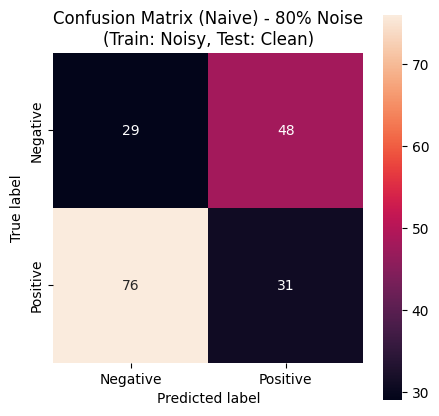

✅ Step 80% completed


===== Training Decision Tree (Naive) with 90% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.25
Precision: 0.26153846153846155
Recall: 0.1588785046728972
F1-score: 0.19767441860465115
Noise 90% - Decision Tree (Naive)
  Accuracy Test:   0.2500 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0031 sec


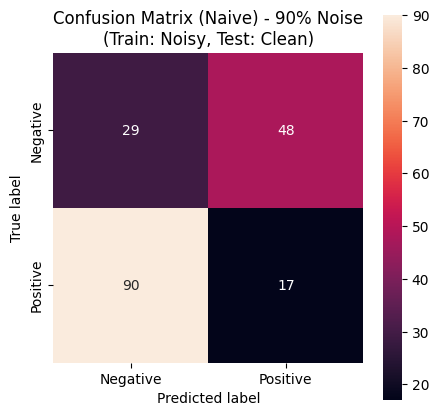

✅ Step 90% completed


===== Training Decision Tree (Naive) with 100% Noise =====
Misure di performance globali decision tree naive

Accuracy: 0.2391304347826087
Precision: 0.31868131868131866
Recall: 0.27102803738317754
F1-score: 0.29292929292929293
Noise 100% - Decision Tree (Naive)
  Accuracy Test:   0.2391 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0031 sec


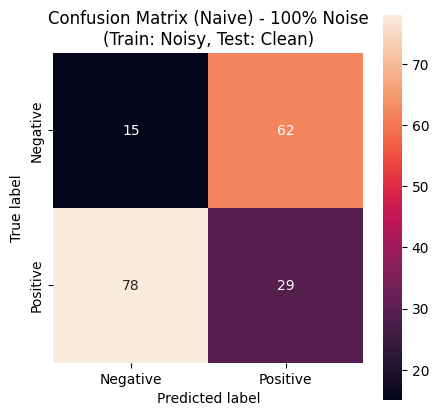

✅ Step 100% completed


===== Training Decision Tree (Optimized) with 0% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036
Noise 0% - Decision Tree (Optimized)
  Accuracy Test:   0.7989 (valutato su dati puliti)
  Accuracy Train:  0.8651 (valutato su dati rumorosi)
  Training time:   0.0012 sec


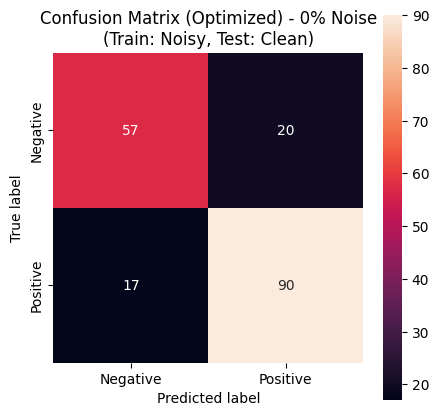

✅ Step 0% completed


===== Training Decision Tree (Optimized) with 10% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036
Noise 10% - Decision Tree (Optimized)
  Accuracy Test:   0.7989 (valutato su dati puliti)
  Accuracy Train:  0.7956 (valutato su dati rumorosi)
  Training time:   0.0017 sec


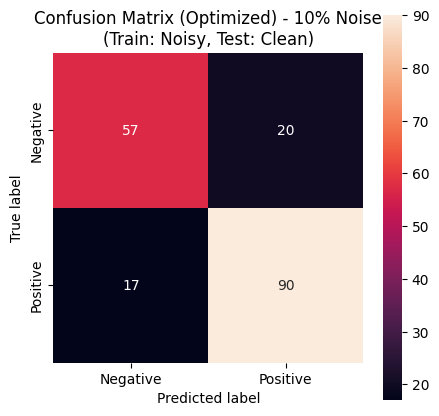

✅ Step 10% completed


===== Training Decision Tree (Optimized) with 20% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.8097826086956522
Precision: 0.8333333333333334
Recall: 0.8411214953271028
F1-score: 0.8372093023255814
Noise 20% - Decision Tree (Optimized)
  Accuracy Test:   0.8098 (valutato su dati puliti)
  Accuracy Train:  0.7439 (valutato su dati rumorosi)
  Training time:   0.0013 sec


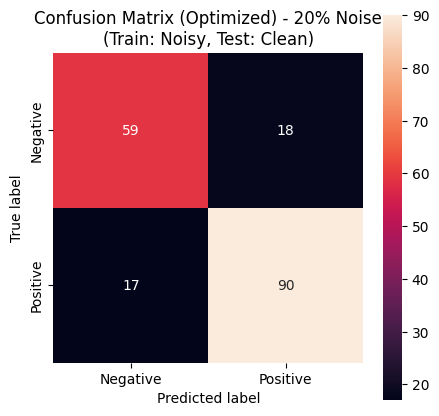

✅ Step 20% completed


===== Training Decision Tree (Optimized) with 30% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.8043478260869565
Precision: 0.808695652173913
Recall: 0.8691588785046729
F1-score: 0.8378378378378378
Noise 30% - Decision Tree (Optimized)
  Accuracy Test:   0.8043 (valutato su dati puliti)
  Accuracy Train:  0.6662 (valutato su dati rumorosi)
  Training time:   0.0010 sec


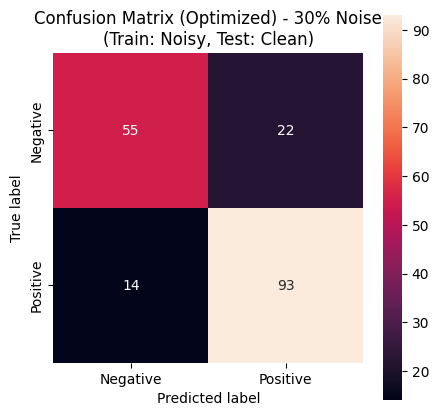

✅ Step 30% completed


===== Training Decision Tree (Optimized) with 40% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.7282608695652174
Precision: 0.8518518518518519
Recall: 0.6448598130841121
F1-score: 0.7340425531914894
Noise 40% - Decision Tree (Optimized)
  Accuracy Test:   0.7283 (valutato su dati puliti)
  Accuracy Train:  0.6104 (valutato su dati rumorosi)
  Training time:   0.0013 sec


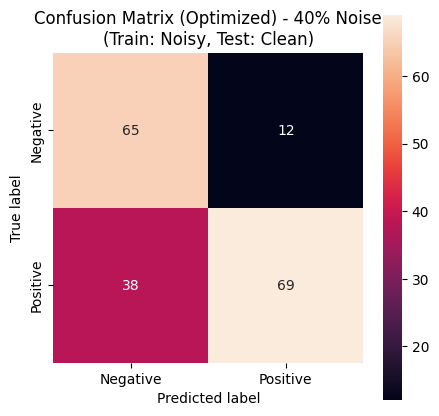

✅ Step 40% completed


===== Training Decision Tree (Optimized) with 50% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.44021739130434784
Precision: 1.0
Recall: 0.037383177570093455
F1-score: 0.07207207207207207
Noise 50% - Decision Tree (Optimized)
  Accuracy Test:   0.4402 (valutato su dati puliti)
  Accuracy Train:  0.5327 (valutato su dati rumorosi)
  Training time:   0.0014 sec


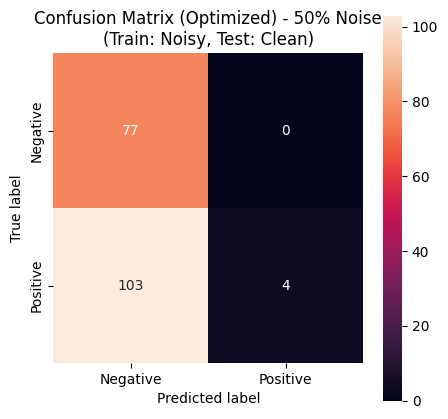

✅ Step 50% completed


===== Training Decision Tree (Optimized) with 60% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.22282608695652173
Precision: 0.125
Recall: 0.056074766355140186
F1-score: 0.07741935483870968
Noise 60% - Decision Tree (Optimized)
  Accuracy Test:   0.2228 (valutato su dati puliti)
  Accuracy Train:  0.6213 (valutato su dati rumorosi)
  Training time:   0.0012 sec


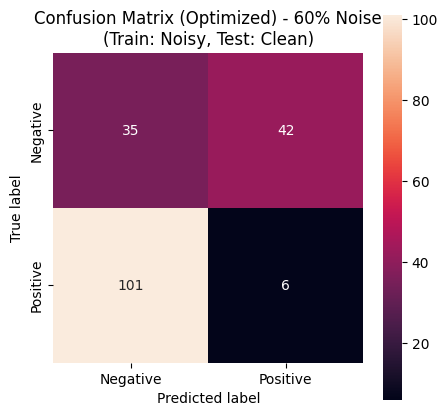

✅ Step 60% completed


===== Training Decision Tree (Optimized) with 70% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.21739130434782608
Precision: 0.2318840579710145
Recall: 0.14953271028037382
F1-score: 0.18181818181818182
Noise 70% - Decision Tree (Optimized)
  Accuracy Test:   0.2174 (valutato su dati puliti)
  Accuracy Train:  0.6744 (valutato su dati rumorosi)
  Training time:   0.0012 sec


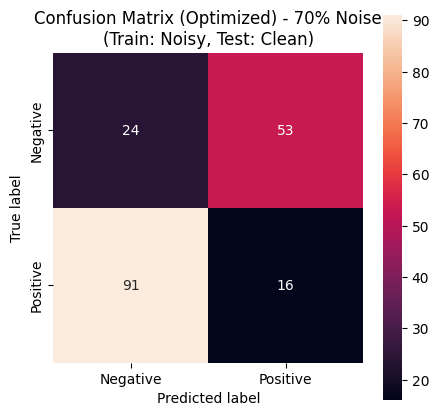

✅ Step 70% completed


===== Training Decision Tree (Optimized) with 80% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.1956521739130435
Precision: 0.22666666666666666
Recall: 0.1588785046728972
F1-score: 0.18681318681318682
Noise 80% - Decision Tree (Optimized)
  Accuracy Test:   0.1957 (valutato su dati puliti)
  Accuracy Train:  0.7330 (valutato su dati rumorosi)
  Training time:   0.0011 sec


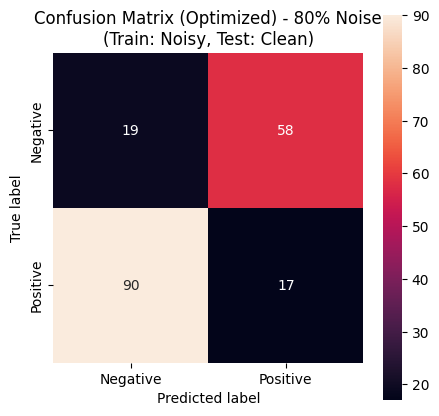

✅ Step 80% completed


===== Training Decision Tree (Optimized) with 90% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.20108695652173914
Precision: 0.22972972972972974
Recall: 0.1588785046728972
F1-score: 0.1878453038674033
Noise 90% - Decision Tree (Optimized)
  Accuracy Test:   0.2011 (valutato su dati puliti)
  Accuracy Train:  0.8079 (valutato su dati rumorosi)
  Training time:   0.0012 sec


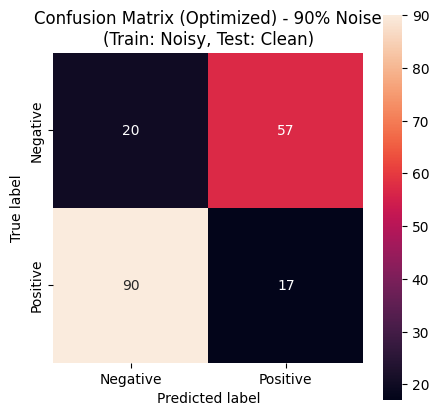

✅ Step 90% completed


===== Training Decision Tree (Optimized) with 100% Noise =====
Misure di performance globali decision tree optimized

Accuracy: 0.20108695652173914
Precision: 0.22972972972972974
Recall: 0.1588785046728972
F1-score: 0.1878453038674033
Noise 100% - Decision Tree (Optimized)
  Accuracy Test:   0.2011 (valutato su dati puliti)
  Accuracy Train:  0.8651 (valutato su dati rumorosi)
  Training time:   0.0010 sec


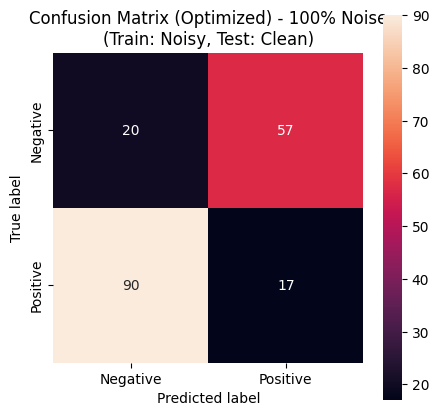

✅ Step 100% completed



--- INIZIO TRAINING: SVM ---

===== Training SVM (Naive) with 0% Noise =====
Misure di performance globali svm naive

Accuracy: 0.6739130434782609
Precision: 0.7238095238095238
Recall: 0.7102803738317757
F1-score: 0.7169811320754716
Noise 0% - SVM (Naive)
  Accuracy Test:   0.6739 (valutato su dati puliti)
  Accuracy Train:  0.7044 (valutato su dati rumorosi)
  Training time:   0.0121 sec


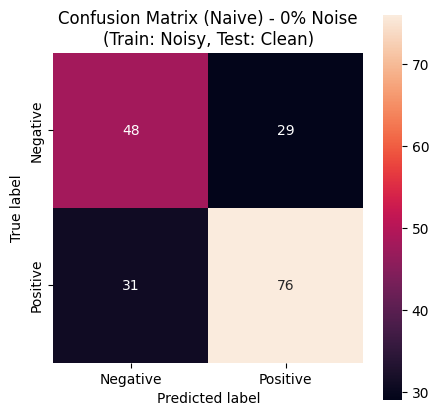

✅ Step 0% completed


===== Training SVM (Naive) with 10% Noise =====
Misure di performance globali svm naive

Accuracy: 0.6847826086956522
Precision: 0.7378640776699029
Recall: 0.7102803738317757
F1-score: 0.7238095238095238
Noise 10% - SVM (Naive)
  Accuracy Test:   0.6848 (valutato su dati puliti)
  Accuracy Train:  0.6771 (valutato su dati rumorosi)
  Training time:   0.0088 sec


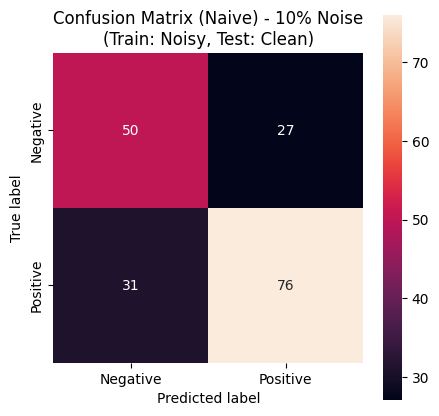

✅ Step 10% completed


===== Training SVM (Naive) with 20% Noise =====
Misure di performance globali svm naive

Accuracy: 0.6793478260869565
Precision: 0.74
Recall: 0.6915887850467289
F1-score: 0.714975845410628
Noise 20% - SVM (Naive)
  Accuracy Test:   0.6793 (valutato su dati puliti)
  Accuracy Train:  0.6471 (valutato su dati rumorosi)
  Training time:   0.0087 sec


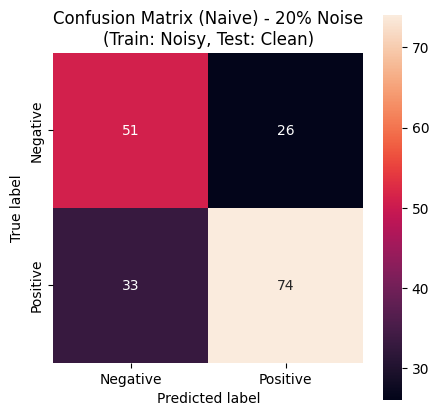

✅ Step 20% completed


===== Training SVM (Naive) with 30% Noise =====
Misure di performance globali svm naive

Accuracy: 0.6195652173913043
Precision: 0.7466666666666667
Recall: 0.5233644859813084
F1-score: 0.6153846153846154
Noise 30% - SVM (Naive)
  Accuracy Test:   0.6196 (valutato su dati puliti)
  Accuracy Train:  0.5886 (valutato su dati rumorosi)
  Training time:   0.0093 sec


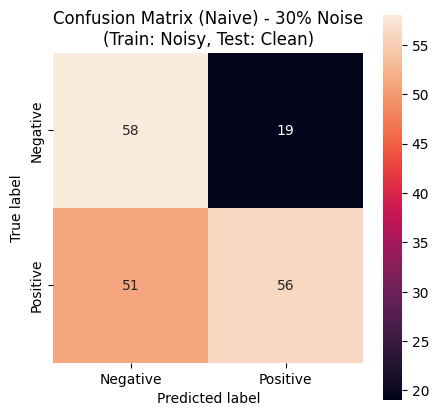

✅ Step 30% completed


===== Training SVM (Naive) with 40% Noise =====
Misure di performance globali svm naive

Accuracy: 0.41847826086956524
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Noise 40% - SVM (Naive)
  Accuracy Test:   0.4185 (valutato su dati puliti)
  Accuracy Train:  0.5368 (valutato su dati rumorosi)
  Training time:   0.0095 sec


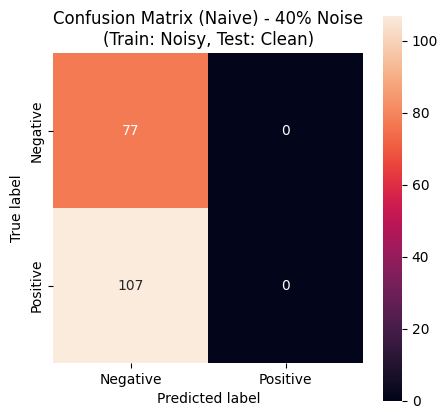

✅ Step 40% completed


===== Training SVM (Naive) with 50% Noise =====
Misure di performance globali svm naive

Accuracy: 0.42934782608695654
Precision: 1.0
Recall: 0.018691588785046728
F1-score: 0.03669724770642202
Noise 50% - SVM (Naive)
  Accuracy Test:   0.4293 (valutato su dati puliti)
  Accuracy Train:  0.5259 (valutato su dati rumorosi)
  Training time:   0.0188 sec


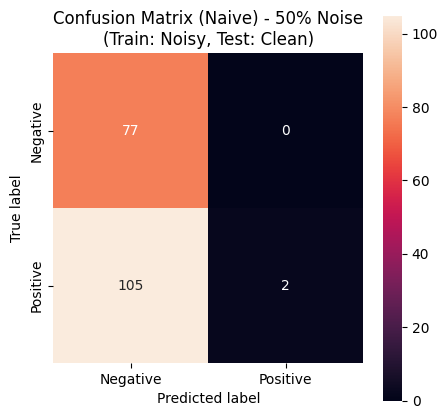

✅ Step 50% completed


===== Training SVM (Naive) with 60% Noise =====
Misure di performance globali svm naive

Accuracy: 0.3858695652173913
Precision: 0.2857142857142857
Recall: 0.037383177570093455
F1-score: 0.06611570247933884
Noise 60% - SVM (Naive)
  Accuracy Test:   0.3859 (valutato su dati puliti)
  Accuracy Train:  0.5545 (valutato su dati rumorosi)
  Training time:   0.0142 sec


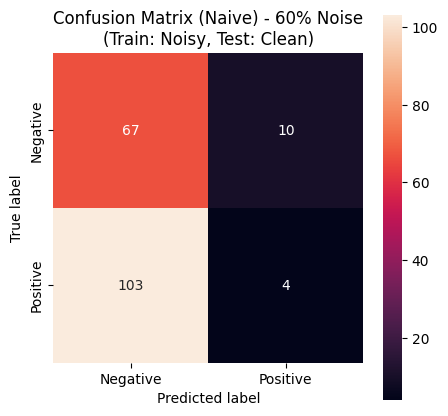

✅ Step 60% completed


===== Training SVM (Naive) with 70% Noise =====
Misure di performance globali svm naive

Accuracy: 0.33695652173913043
Precision: 0.3333333333333333
Recall: 0.14018691588785046
F1-score: 0.19736842105263158
Noise 70% - SVM (Naive)
  Accuracy Test:   0.3370 (valutato su dati puliti)
  Accuracy Train:  0.6253 (valutato su dati rumorosi)
  Training time:   0.0091 sec


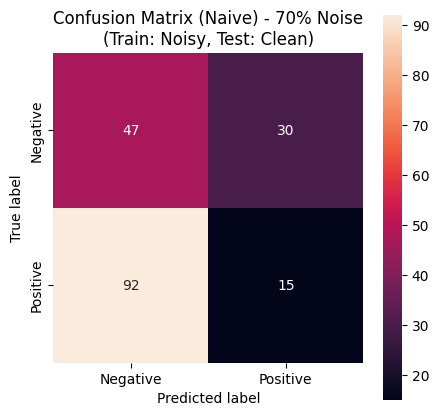

✅ Step 70% completed


===== Training SVM (Naive) with 80% Noise =====
Misure di performance globali svm naive

Accuracy: 0.33152173913043476
Precision: 0.35714285714285715
Recall: 0.18691588785046728
F1-score: 0.24539877300613497
Noise 80% - SVM (Naive)
  Accuracy Test:   0.3315 (valutato su dati puliti)
  Accuracy Train:  0.6471 (valutato su dati rumorosi)
  Training time:   0.0089 sec


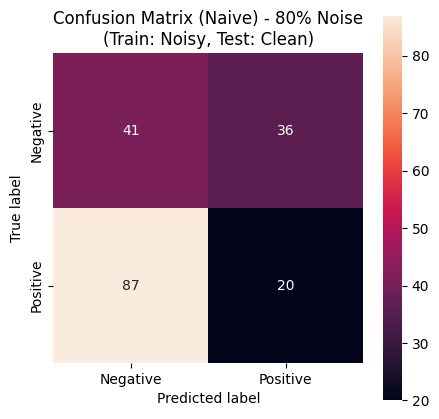

✅ Step 80% completed


===== Training SVM (Naive) with 90% Noise =====
Misure di performance globali svm naive

Accuracy: 0.31521739130434784
Precision: 0.3492063492063492
Recall: 0.205607476635514
F1-score: 0.25882352941176473
Noise 90% - SVM (Naive)
  Accuracy Test:   0.3152 (valutato su dati puliti)
  Accuracy Train:  0.6853 (valutato su dati rumorosi)
  Training time:   0.0081 sec


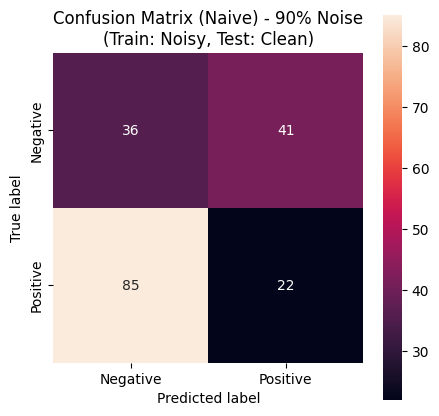

✅ Step 90% completed


===== Training SVM (Naive) with 100% Noise =====
Misure di performance globali svm naive

Accuracy: 0.32608695652173914
Precision: 0.3924050632911392
Recall: 0.2897196261682243
F1-score: 0.3333333333333333
Noise 100% - SVM (Naive)
  Accuracy Test:   0.3261 (valutato su dati puliti)
  Accuracy Train:  0.7044 (valutato su dati rumorosi)
  Training time:   0.0081 sec


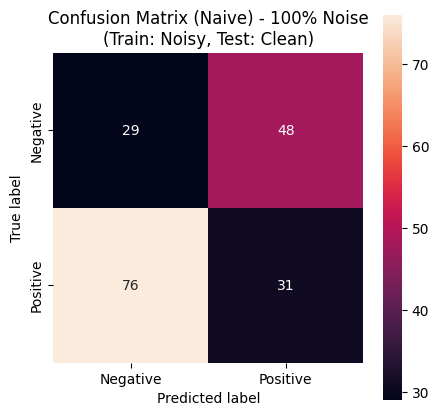

✅ Step 100% completed


===== Training SVM (Optimized) with 0% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.6141304347826086
Precision: 0.652542372881356
Recall: 0.719626168224299
F1-score: 0.6844444444444444
Noise 0% - SVM (Optimized)
  Accuracy Test:   0.6141 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0124 sec


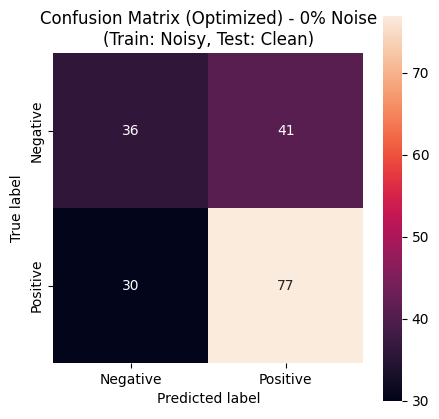

✅ Step 0% completed


===== Training SVM (Optimized) with 10% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.625
Precision: 0.6610169491525424
Recall: 0.7289719626168224
F1-score: 0.6933333333333334
Noise 10% - SVM (Optimized)
  Accuracy Test:   0.6250 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0124 sec


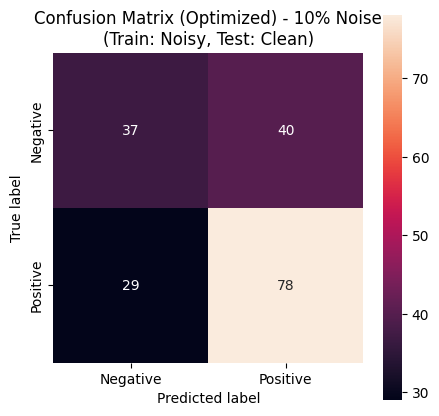

✅ Step 10% completed


===== Training SVM (Optimized) with 20% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.6358695652173914
Precision: 0.6923076923076923
Recall: 0.6728971962616822
F1-score: 0.6824644549763034
Noise 20% - SVM (Optimized)
  Accuracy Test:   0.6359 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0129 sec


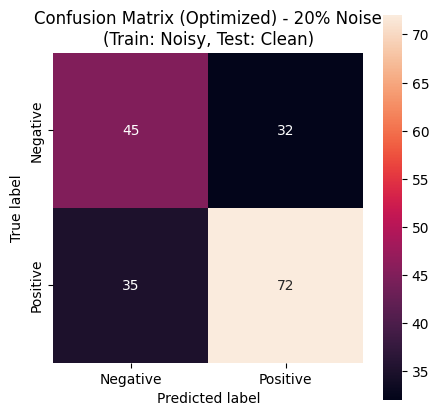

✅ Step 20% completed


===== Training SVM (Optimized) with 30% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.6467391304347826
Precision: 0.71875
Recall: 0.6448598130841121
F1-score: 0.6798029556650246
Noise 30% - SVM (Optimized)
  Accuracy Test:   0.6467 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0129 sec


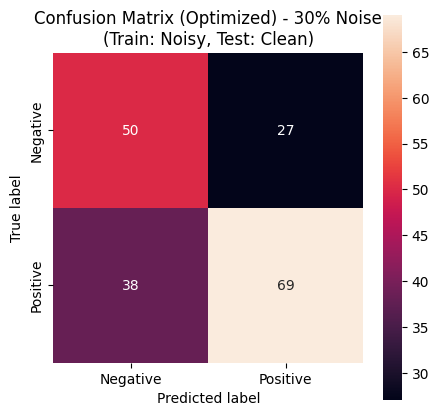

✅ Step 30% completed


===== Training SVM (Optimized) with 40% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.5434782608695652
Precision: 0.6455696202531646
Recall: 0.4766355140186916
F1-score: 0.5483870967741935
Noise 40% - SVM (Optimized)
  Accuracy Test:   0.5435 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0135 sec


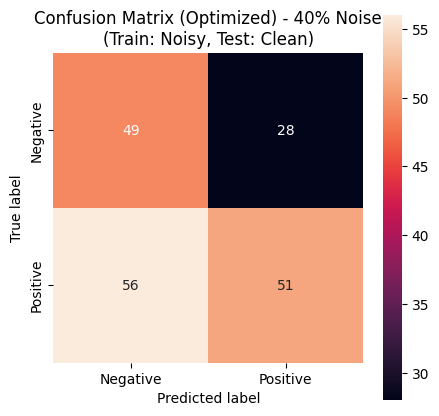

✅ Step 40% completed


===== Training SVM (Optimized) with 50% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.5217391304347826
Precision: 0.611764705882353
Recall: 0.48598130841121495
F1-score: 0.5416666666666666
Noise 50% - SVM (Optimized)
  Accuracy Test:   0.5217 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0129 sec


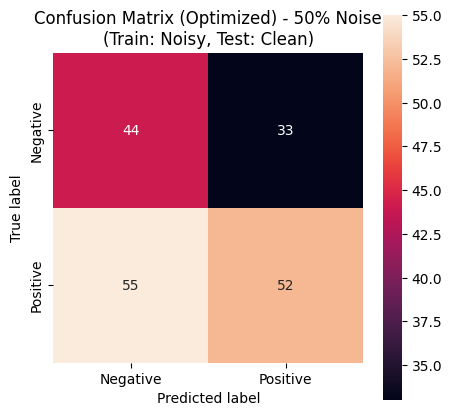

✅ Step 50% completed


===== Training SVM (Optimized) with 60% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.44021739130434784
Precision: 0.5285714285714286
Recall: 0.34579439252336447
F1-score: 0.4180790960451977
Noise 60% - SVM (Optimized)
  Accuracy Test:   0.4402 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0131 sec


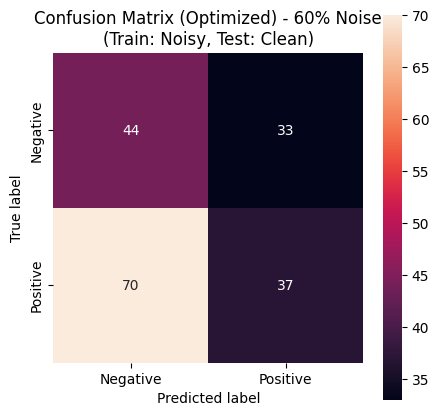

✅ Step 60% completed


===== Training SVM (Optimized) with 70% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.41304347826086957
Precision: 0.4935064935064935
Recall: 0.35514018691588783
F1-score: 0.41304347826086957
Noise 70% - SVM (Optimized)
  Accuracy Test:   0.4130 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0127 sec


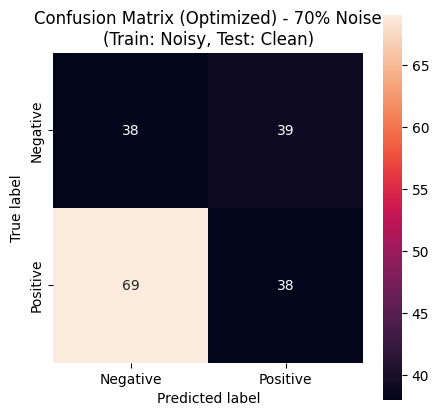

✅ Step 70% completed


===== Training SVM (Optimized) with 80% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.43478260869565216
Precision: 0.5205479452054794
Recall: 0.35514018691588783
F1-score: 0.4222222222222222
Noise 80% - SVM (Optimized)
  Accuracy Test:   0.4348 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0134 sec


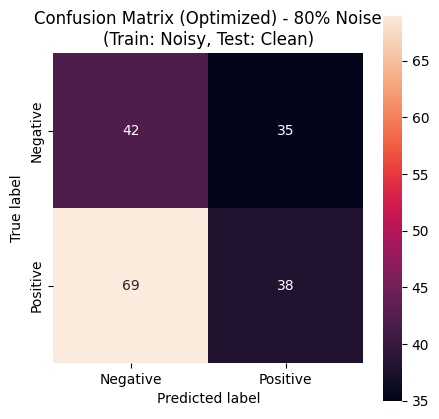

✅ Step 80% completed


===== Training SVM (Optimized) with 90% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.3967391304347826
Precision: 0.4696969696969697
Recall: 0.2897196261682243
F1-score: 0.3583815028901734
Noise 90% - SVM (Optimized)
  Accuracy Test:   0.3967 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0129 sec


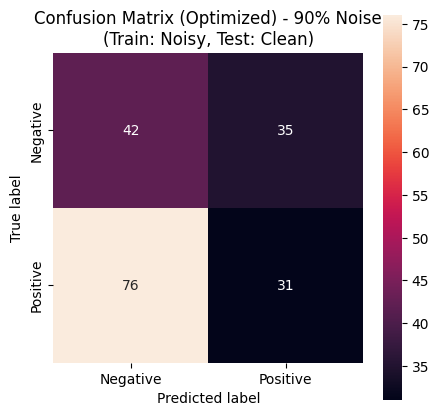

✅ Step 90% completed


===== Training SVM (Optimized) with 100% Noise =====
Misure di performance globali svm optimized

Accuracy: 0.3858695652173913
Precision: 0.45454545454545453
Recall: 0.2803738317757009
F1-score: 0.3468208092485549
Noise 100% - SVM (Optimized)
  Accuracy Test:   0.3859 (valutato su dati puliti)
  Accuracy Train:  1.0000 (valutato su dati rumorosi)
  Training time:   0.0127 sec


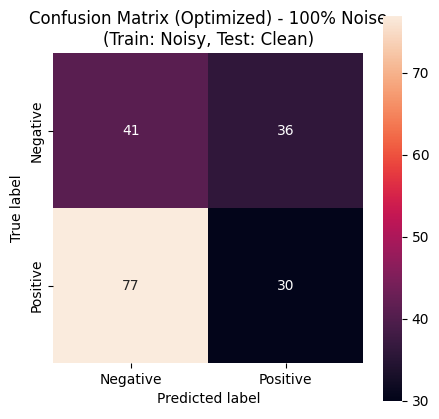

✅ Step 100% completed



--- INIZIO TRAINING: NEURAL NETWORK ---

===== Training Neural Network (Naive) with 0% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.8369565217391305
Precision: 0.8130081300813008
Recall: 0.9345794392523364
F1-score: 0.8695652173913043
Noise 0% - Neural Network (Naive)
  Accuracy Test:   0.8370 (valutato su dati puliti)
  Accuracy Train:  0.8556 (valutato su dati rumorosi)
  Training time:   0.0728 sec


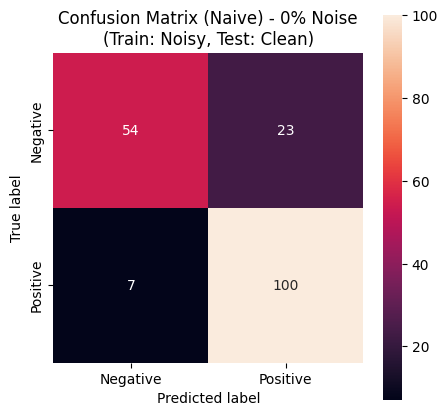

✅ Step 0% completed


===== Training Neural Network (Naive) with 10% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.7717391304347826
Precision: 0.922077922077922
Recall: 0.6635514018691588
F1-score: 0.7717391304347826
Noise 10% - Neural Network (Naive)
  Accuracy Test:   0.7717 (valutato su dati puliti)
  Accuracy Train:  0.7602 (valutato su dati rumorosi)
  Training time:   0.0511 sec


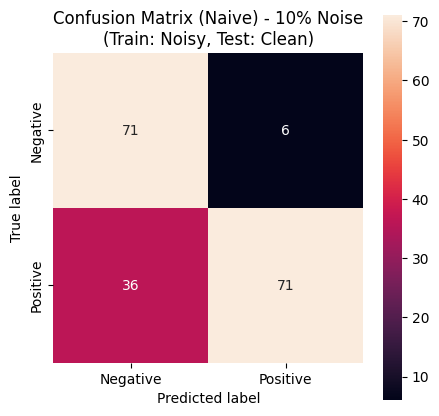

✅ Step 10% completed


===== Training Neural Network (Naive) with 20% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.7989130434782609
Precision: 0.7692307692307693
Recall: 0.9345794392523364
F1-score: 0.8438818565400844
Noise 20% - Neural Network (Naive)
  Accuracy Test:   0.7989 (valutato su dati puliti)
  Accuracy Train:  0.7112 (valutato su dati rumorosi)
  Training time:   0.0852 sec


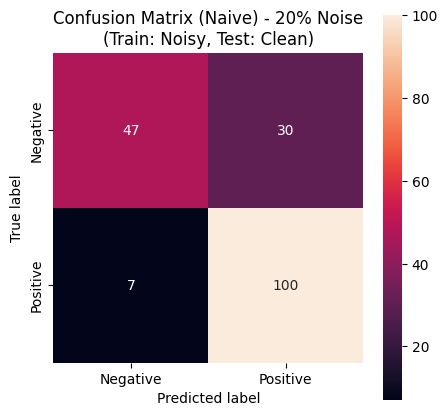

✅ Step 20% completed


===== Training Neural Network (Naive) with 30% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.7717391304347826
Precision: 0.7372262773722628
Recall: 0.9439252336448598
F1-score: 0.8278688524590164
Noise 30% - Neural Network (Naive)
  Accuracy Test:   0.7717 (valutato su dati puliti)
  Accuracy Train:  0.6240 (valutato su dati rumorosi)
  Training time:   0.0603 sec


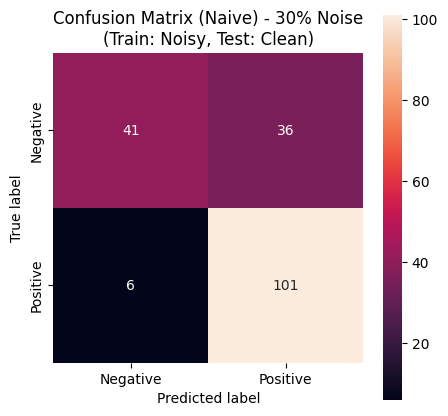

✅ Step 30% completed


===== Training Neural Network (Naive) with 40% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.6630434782608695
Precision: 0.7586206896551724
Recall: 0.616822429906542
F1-score: 0.6804123711340206
Noise 40% - Neural Network (Naive)
  Accuracy Test:   0.6630 (valutato su dati puliti)
  Accuracy Train:  0.5995 (valutato su dati rumorosi)
  Training time:   0.0472 sec


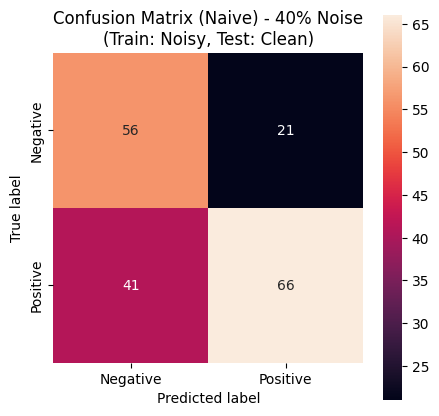

✅ Step 40% completed


===== Training Neural Network (Naive) with 50% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.44565217391304346
Precision: 0.5714285714285714
Recall: 0.18691588785046728
F1-score: 0.28169014084507044
Noise 50% - Neural Network (Naive)
  Accuracy Test:   0.4457 (valutato su dati puliti)
  Accuracy Train:  0.5668 (valutato su dati rumorosi)
  Training time:   0.0446 sec


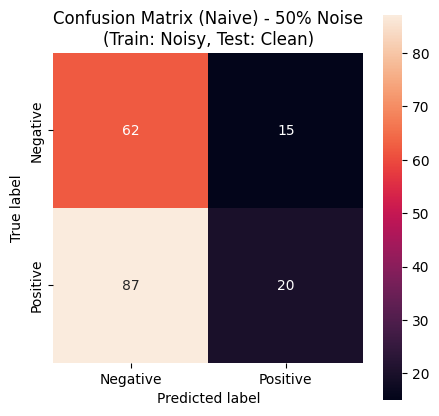

✅ Step 50% completed


===== Training Neural Network (Naive) with 60% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.31521739130434784
Precision: 0.4
Recall: 0.35514018691588783
F1-score: 0.37623762376237624
Noise 60% - Neural Network (Naive)
  Accuracy Test:   0.3152 (valutato su dati puliti)
  Accuracy Train:  0.5858 (valutato su dati rumorosi)
  Training time:   0.0710 sec


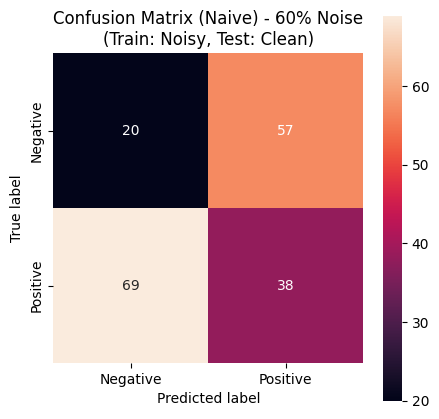

✅ Step 60% completed


===== Training Neural Network (Naive) with 70% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.22826086956521738
Precision: 0.3076923076923077
Recall: 0.2616822429906542
F1-score: 0.2828282828282828
Noise 70% - Neural Network (Naive)
  Accuracy Test:   0.2283 (valutato su dati puliti)
  Accuracy Train:  0.6485 (valutato su dati rumorosi)
  Training time:   0.0651 sec


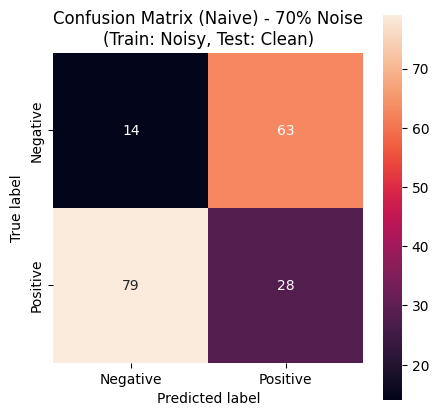

✅ Step 70% completed


===== Training Neural Network (Naive) with 80% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.18478260869565216
Precision: 0.12280701754385964
Recall: 0.06542056074766354
F1-score: 0.08536585365853659
Noise 80% - Neural Network (Naive)
  Accuracy Test:   0.1848 (valutato su dati puliti)
  Accuracy Train:  0.7398 (valutato su dati rumorosi)
  Training time:   0.0963 sec


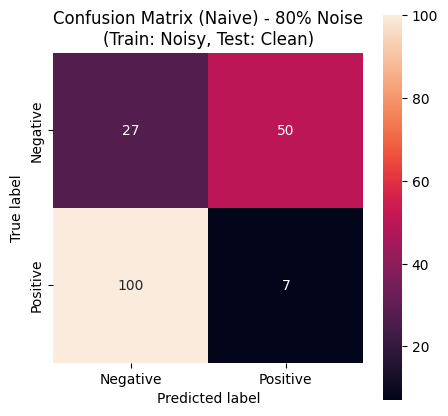

✅ Step 80% completed


===== Training Neural Network (Naive) with 90% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.17391304347826086
Precision: 0.11864406779661017
Recall: 0.06542056074766354
F1-score: 0.08433734939759036
Noise 90% - Neural Network (Naive)
  Accuracy Test:   0.1739 (valutato su dati puliti)
  Accuracy Train:  0.8079 (valutato su dati rumorosi)
  Training time:   0.1782 sec


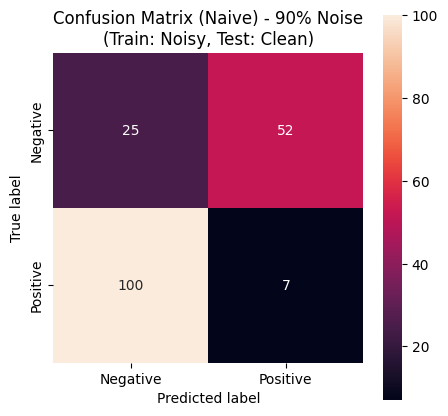

✅ Step 90% completed


===== Training Neural Network (Naive) with 100% Noise =====
Misure di performance globali neural network naive

Accuracy: 0.20108695652173914
Precision: 0.2619047619047619
Recall: 0.205607476635514
F1-score: 0.23036649214659685
Noise 100% - Neural Network (Naive)
  Accuracy Test:   0.2011 (valutato su dati puliti)
  Accuracy Train:  0.8638 (valutato su dati rumorosi)
  Training time:   0.0825 sec


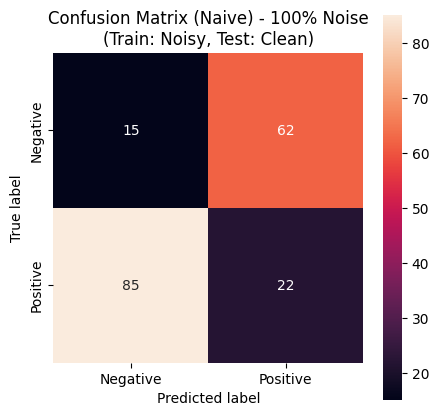

✅ Step 100% completed


===== Training Neural Network (Optimized) with 0% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726
Noise 0% - Neural Network (Optimized)
  Accuracy Test:   0.8424 (valutato su dati puliti)
  Accuracy Train:  0.8747 (valutato su dati rumorosi)
  Training time:   0.1048 sec


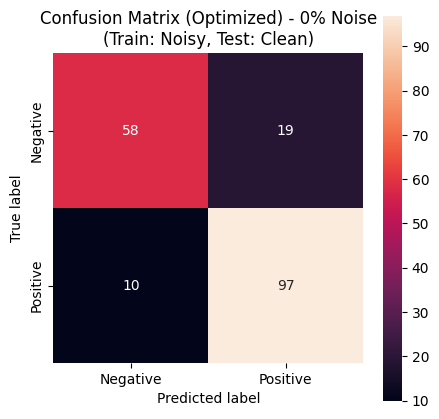

✅ Step 0% completed


===== Training Neural Network (Optimized) with 10% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.8152173913043478
Precision: 0.792
Recall: 0.9252336448598131
F1-score: 0.853448275862069
Noise 10% - Neural Network (Optimized)
  Accuracy Test:   0.8152 (valutato su dati puliti)
  Accuracy Train:  0.7970 (valutato su dati rumorosi)
  Training time:   0.0679 sec


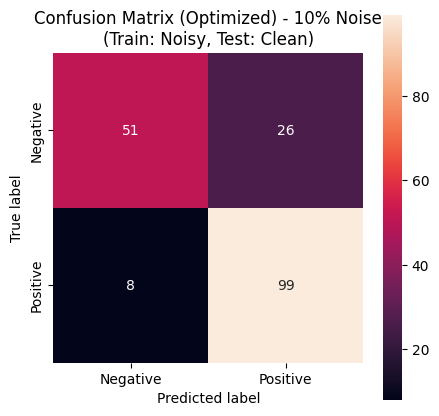

✅ Step 10% completed


===== Training Neural Network (Optimized) with 20% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.8043478260869565
Precision: 0.7669172932330827
Recall: 0.9532710280373832
F1-score: 0.85
Noise 20% - Neural Network (Optimized)
  Accuracy Test:   0.8043 (valutato su dati puliti)
  Accuracy Train:  0.7098 (valutato su dati rumorosi)
  Training time:   0.0868 sec


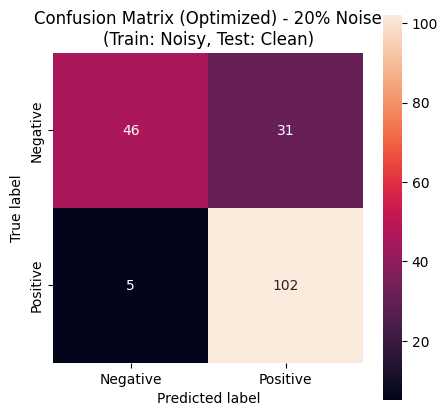

✅ Step 20% completed


===== Training Neural Network (Optimized) with 30% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.6086956521739131
Precision: 0.9487179487179487
Recall: 0.34579439252336447
F1-score: 0.5068493150684932
Noise 30% - Neural Network (Optimized)
  Accuracy Test:   0.6087 (valutato su dati puliti)
  Accuracy Train:  0.6213 (valutato su dati rumorosi)
  Training time:   0.0848 sec


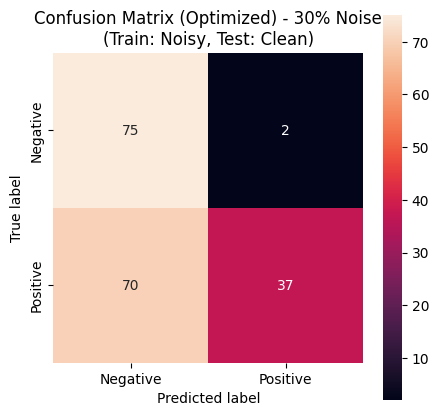

✅ Step 30% completed


===== Training Neural Network (Optimized) with 40% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.47282608695652173
Precision: 1.0
Recall: 0.09345794392523364
F1-score: 0.17094017094017094
Noise 40% - Neural Network (Optimized)
  Accuracy Test:   0.4728 (valutato su dati puliti)
  Accuracy Train:  0.5804 (valutato su dati rumorosi)
  Training time:   0.0426 sec


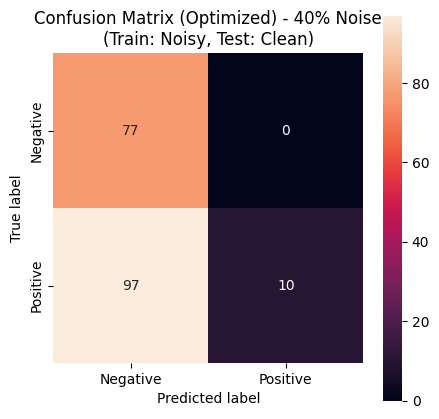

✅ Step 40% completed


===== Training Neural Network (Optimized) with 50% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.42934782608695654
Precision: 0.5833333333333334
Recall: 0.06542056074766354
F1-score: 0.11764705882352941
Noise 50% - Neural Network (Optimized)
  Accuracy Test:   0.4293 (valutato su dati puliti)
  Accuracy Train:  0.5395 (valutato su dati rumorosi)
  Training time:   0.0442 sec


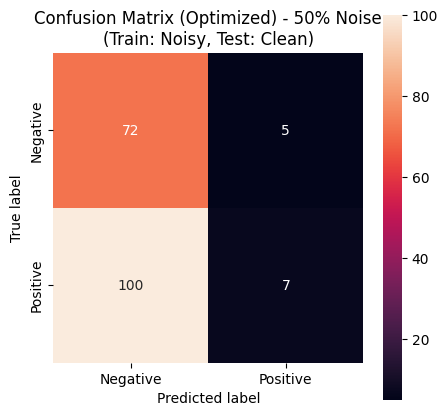

✅ Step 50% completed


===== Training Neural Network (Optimized) with 60% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.29347826086956524
Precision: 0.3114754098360656
Recall: 0.17757009345794392
F1-score: 0.2261904761904762
Noise 60% - Neural Network (Optimized)
  Accuracy Test:   0.2935 (valutato su dati puliti)
  Accuracy Train:  0.6417 (valutato su dati rumorosi)
  Training time:   0.0853 sec


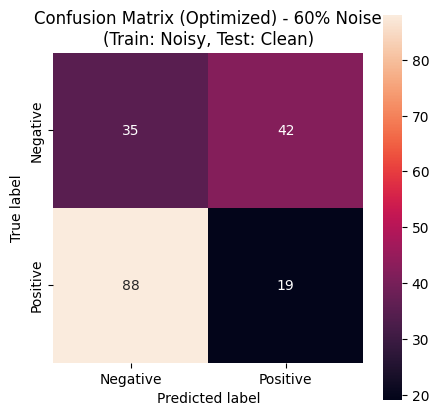

✅ Step 60% completed


===== Training Neural Network (Optimized) with 70% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.2391304347826087
Precision: 0.24615384615384617
Recall: 0.14953271028037382
F1-score: 0.18604651162790697
Noise 70% - Neural Network (Optimized)
  Accuracy Test:   0.2391 (valutato su dati puliti)
  Accuracy Train:  0.6921 (valutato su dati rumorosi)
  Training time:   0.1528 sec


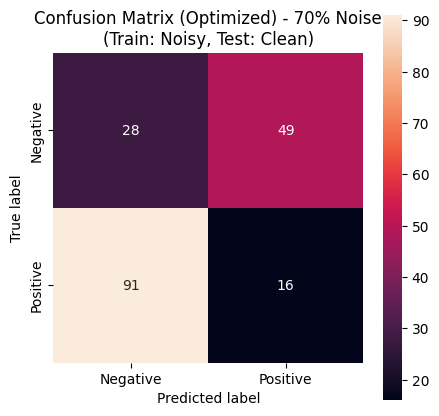

✅ Step 70% completed


===== Training Neural Network (Optimized) with 80% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.21195652173913043
Precision: 0.10416666666666667
Recall: 0.04672897196261682
F1-score: 0.06451612903225806
Noise 80% - Neural Network (Optimized)
  Accuracy Test:   0.2120 (valutato su dati puliti)
  Accuracy Train:  0.7398 (valutato su dati rumorosi)
  Training time:   0.0913 sec


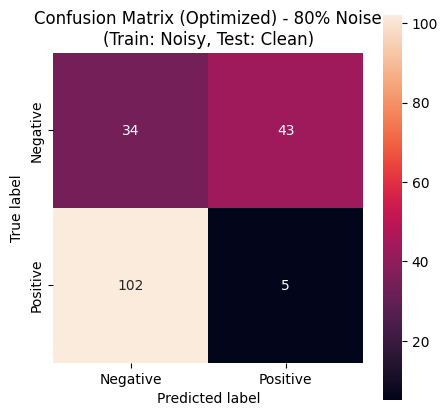

✅ Step 80% completed


===== Training Neural Network (Optimized) with 90% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.18478260869565216
Precision: 0.1791044776119403
Recall: 0.11214953271028037
F1-score: 0.13793103448275862
Noise 90% - Neural Network (Optimized)
  Accuracy Test:   0.1848 (valutato su dati puliti)
  Accuracy Train:  0.8093 (valutato su dati rumorosi)
  Training time:   0.2436 sec


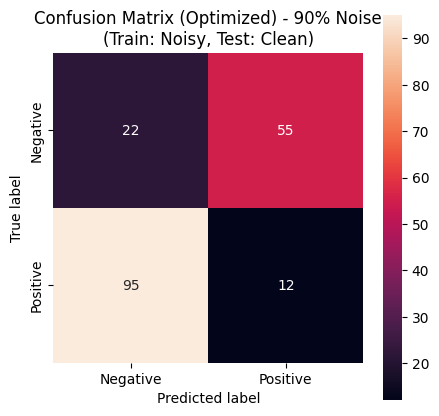

✅ Step 90% completed


===== Training Neural Network (Optimized) with 100% Noise =====
Misure di performance globali neural network optimized

Accuracy: 0.20108695652173914
Precision: 0.2727272727272727
Recall: 0.22429906542056074
F1-score: 0.24615384615384617
Noise 100% - Neural Network (Optimized)
  Accuracy Test:   0.2011 (valutato su dati puliti)
  Accuracy Train:  0.8610 (valutato su dati rumorosi)
  Training time:   0.2244 sec


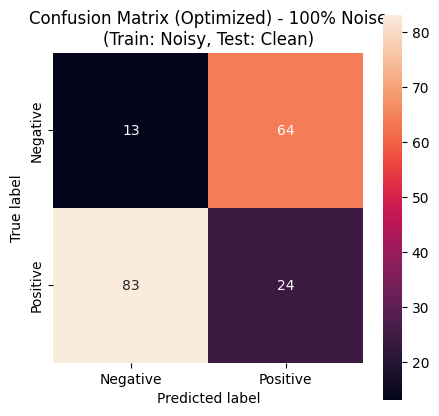

✅ Step 100% completed



In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import time

feature_importances = {}

# Carica i modelli ottimizzati (se già salvati)
best_dt_params = joblib.load('best_decision_tree_model.pkl')
best_svm_params = joblib.load('best_svm_model.pkl')
best_nn_params = joblib.load('best_nn_model.pkl')
best_nn_params = {
    'activation': best_nn_params.get('model__activation', 'relu'),
    'hidden_layer_sizes': best_nn_params.get('model__hidden_layer_sizes', (100,)),
    'random_state': 42,
    'max_iter': 1000
}

# Split del dataset originale per ottenere il test set pulito
X_original = df.drop('HeartDisease', axis=1)
y_original = df['HeartDisease']
X_temp, X_test_clean, y_temp, y_test_clean = train_test_split(
    X_original, y_original, test_size=0.2, random_state=0
)

noisy_datasets = add_progressive_noise(df, 'HeartDisease')

def train_and_evaluate_noisy_labels(
    datasets: dict, 
    X_test_clean: pd.DataFrame, 
    y_test_clean: pd.Series, 
    model_class, 
    model_params: dict, 
    model_name: str, 
    approach_name: str, 
    timing_collector: dict, 
    all_metrics_list: list,
    feature_importances: dict = None
):
    """
    Addestra e valuta modelli su dataset con etichette progressivamente rumorose.
    Il training viene fatto sul set contaminato, il test su un set pulito.
    """

    # Itera sul dizionario di dataset rumorosi { '0%_noise': df0, '10%_noise': df10, ... }
    for noise_key, noisy_df in datasets.items():
        # Estrai la percentuale di rumore dalla chiave del dizionario
        noise_percentage = int(noise_key.split('%')[0])
        
        print(f"\n===== Training {model_name} ({approach_name}) with {noise_percentage}% Noise =====")
        
        # Split del dataset contaminato per ottenere il training set
        X_contaminated = noisy_df.drop('HeartDisease', axis=1)
        y_contaminated = noisy_df['HeartDisease']
        
        # Usiamo solo il training set dal dataset rumoroso. Il test set rimane pulito.
        X_train, _, y_train, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=0
        )
        
        # Dati pronti per il training
        X_train_processed = X_train
        X_test_processed = X_test_clean
        y_test = y_test_clean
        
        # Training del modello
        model = model_class(**model_params)
        start_time = time.time()
        model.fit(X_train_processed, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Salva il tempo di addestramento
        timing_key = f"{model_name.lower().replace(' ', '_')}_{approach_name.lower()}_noise_{noise_percentage}%_training"
        timing_collector[timing_key] = training_time
        
        # Predizioni sul test set pulito e sul training set rumoroso
        y_pred_test = model.predict(X_test_processed)
        y_pred_train = model.predict(X_train_processed)
        
        # Accuracy sul training set per monitorare l'overfitting
        accuracy_train = accuracy_score(y_train, y_pred_train)
        
        # Calcolo delle metriche sul test set pulito
        metrics = calculate_metrics(y_test, y_pred_test, model_name, approach_name, noise_percentage)
        metrics['training_time'] = training_time
        metrics['train_accuracy'] = accuracy_train
        metrics['noise_percentage'] = noise_percentage
        metrics['test_set_type'] = 'clean'
        
        # Aggiunta alle metriche globali
        all_metrics_list.append(metrics)
        
        # Stampa un riassunto per questo step
        print(f"Noise {noise_percentage}% - {model_name} ({approach_name})")
        print(f"  Accuracy Test:   {metrics['accuracy']:.4f} (valutato su dati puliti)")
        print(f"  Accuracy Train:  {accuracy_train:.4f} (valutato su dati rumorosi)")
        print(f"  Training time:   {training_time:.4f} sec")
        
        # Matrice di confusione
        cm = confusion_matrix(y_test, y_pred_test)
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f"Confusion Matrix ({approach_name}) - {noise_percentage}% Noise\n(Train: Noisy, Test: Clean)")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # Salva le feature importances (se applicabile, es. Decision Tree)
        if model_name == 'Decision Tree' and feature_importances is not None:
            key = f"{model_name} - {approach_name}"
            if key not in feature_importances:
                feature_importances[key] = {}
            feature_importances[key][noise_percentage] = model.feature_importances_
        
        print(f"✅ Step {noise_percentage}% completed\n")

print("\n\n--- INIZIO TRAINING: DECISION TREE ---")
train_and_evaluate_noisy_labels(
    datasets=noisy_datasets, X_test_clean=X_test_clean, y_test_clean=y_test_clean,
    model_class=DecisionTreeClassifier, model_params={},
    model_name='Decision Tree', approach_name='Naive',
    timing_collector=timing_collector_noisy, all_metrics_list=all_metrics_noisy,
    feature_importances=feature_importances
)
train_and_evaluate_noisy_labels(
    datasets=noisy_datasets, X_test_clean=X_test_clean, y_test_clean=y_test_clean,
    model_class=DecisionTreeClassifier, model_params=best_dt_params,
    model_name='Decision Tree', approach_name='Optimized',
    timing_collector=timing_collector_noisy, all_metrics_list=all_metrics_noisy,
    feature_importances=feature_importances
)

# --- Support Vector Machine (SVM) ---
print("\n\n--- INIZIO TRAINING: SVM ---")
train_and_evaluate_noisy_labels(
    datasets=noisy_datasets, X_test_clean=X_test_clean, y_test_clean=y_test_clean,
    model_class=SVC, model_params={},
    model_name='SVM', approach_name='Naive',
    timing_collector=timing_collector_noisy, all_metrics_list=all_metrics_noisy
)
train_and_evaluate_noisy_labels(
    datasets=noisy_datasets, X_test_clean=X_test_clean, y_test_clean=y_test_clean,
    model_class=SVC, model_params=best_svm_params,
    model_name='SVM', approach_name='Optimized',
    timing_collector=timing_collector_noisy, all_metrics_list=all_metrics_noisy
)

# --- Neural Network (NN) ---
print("\n\n--- INIZIO TRAINING: NEURAL NETWORK ---")
train_and_evaluate_noisy_labels(
    datasets=noisy_datasets, X_test_clean=X_test_clean, y_test_clean=y_test_clean,
    model_class=MLPClassifier, model_params={},
    model_name='Neural Network', approach_name='Naive',
    timing_collector=timing_collector_noisy, all_metrics_list=all_metrics_noisy
)
train_and_evaluate_noisy_labels(
    datasets=noisy_datasets, X_test_clean=X_test_clean, y_test_clean=y_test_clean,
    model_class=MLPClassifier, model_params=best_nn_params,
    model_name='Neural Network', approach_name='Optimized',
    timing_collector=timing_collector_noisy, all_metrics_list=all_metrics_noisy
)



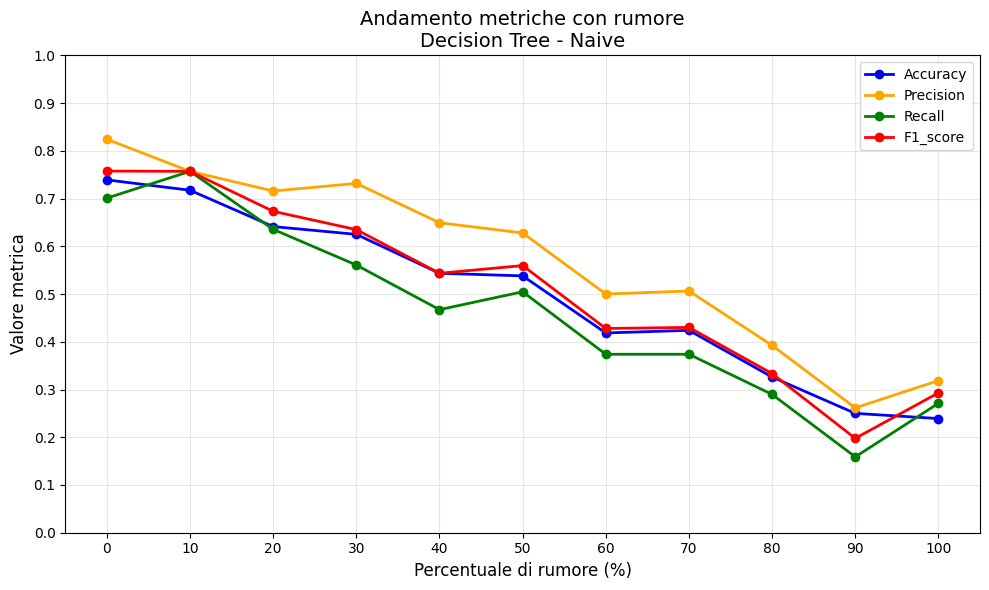

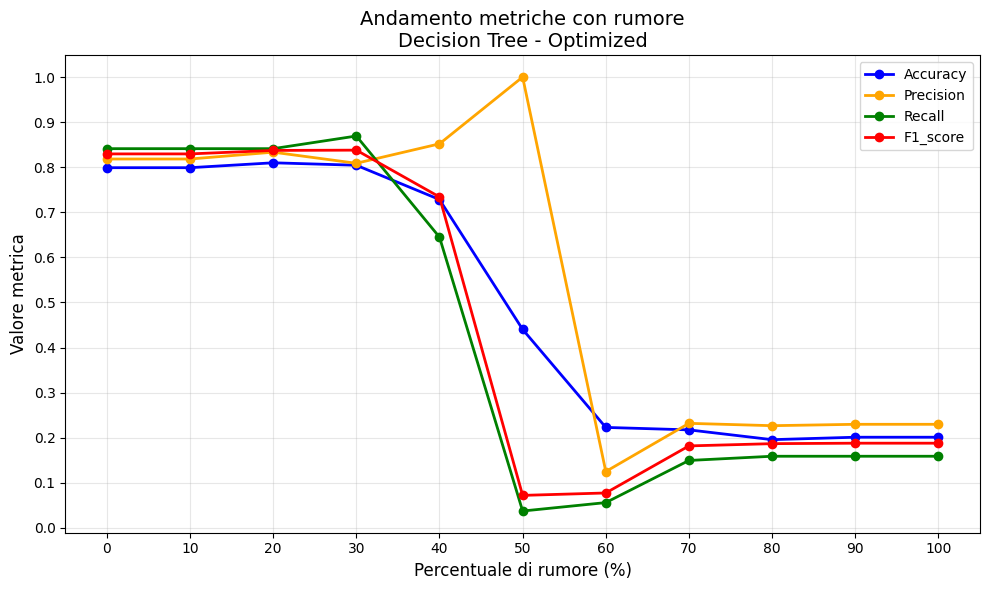

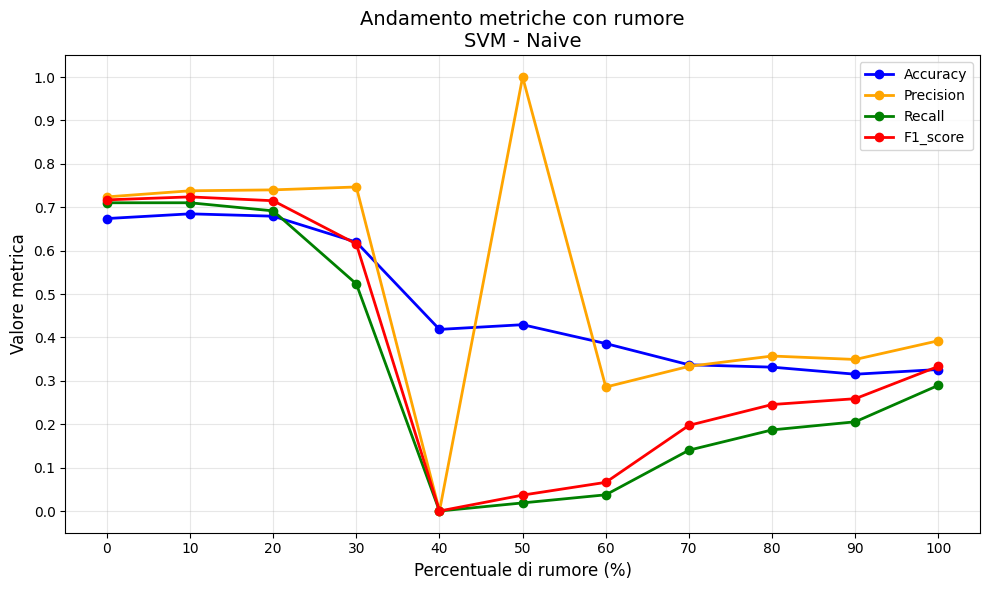

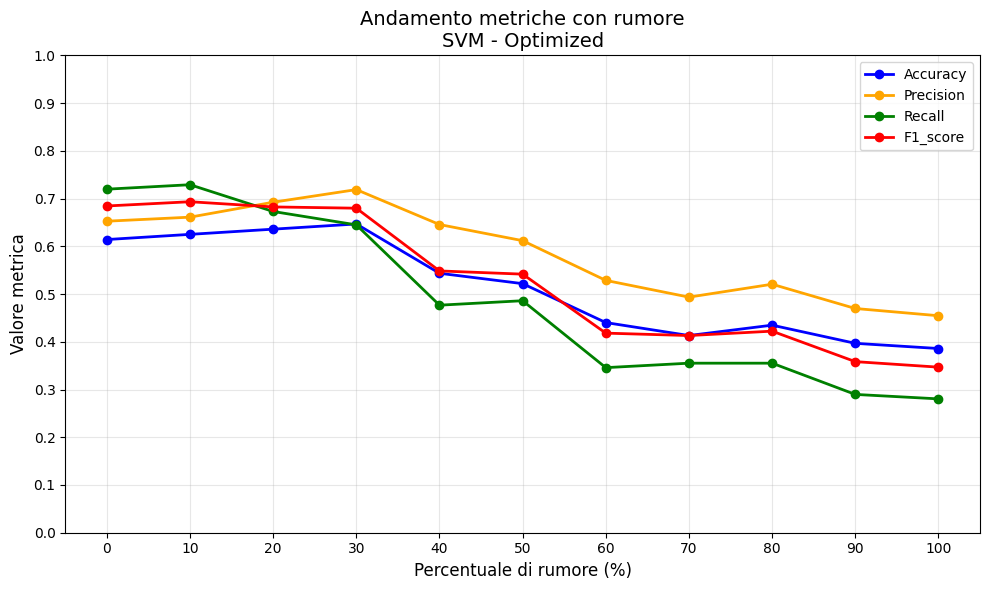

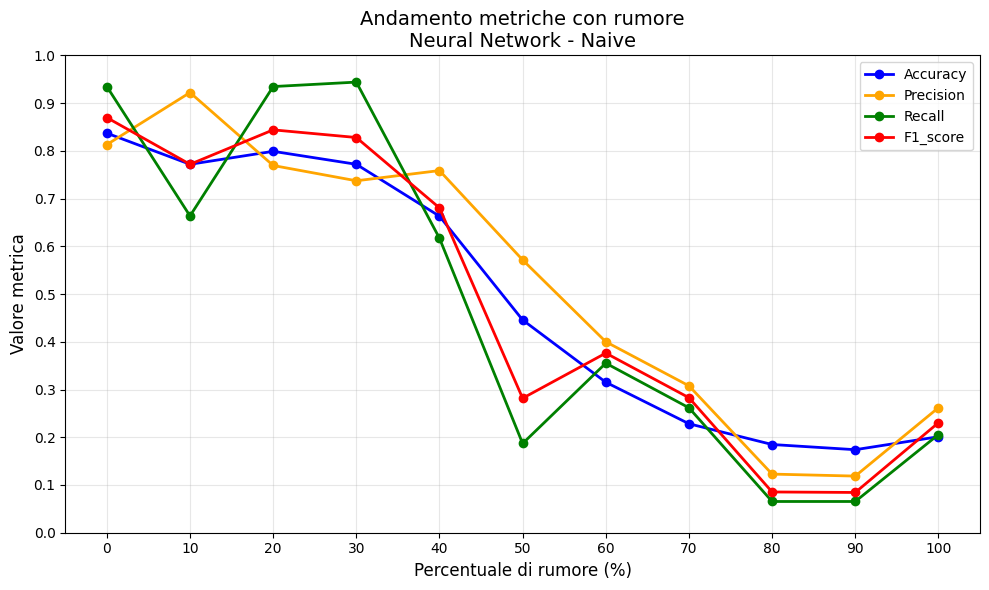

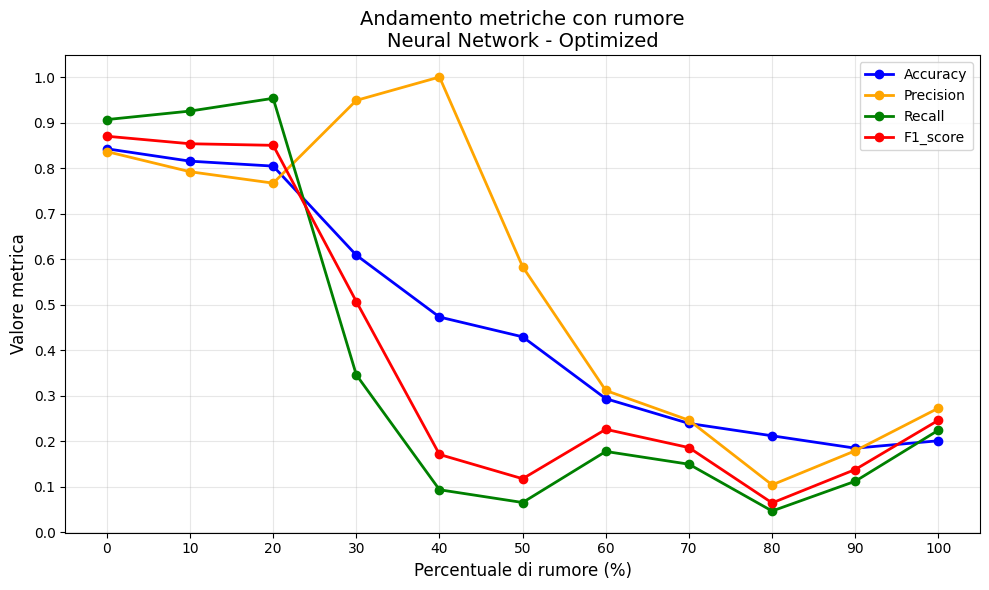

In [117]:
def plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, model_name, approach, figsize=(10, 6)):
    """
    Crea un grafico unico che mostra Accuracy, Precision, Recall e F1-score
    al crescere della percentuale di rumore per un dato modello e approccio,
    includendo il dataset pulito (0% rumore).
    
    Args:
        all_metrics_noisy: lista di metriche calcolate sui dataset rumorosi
        noisy_datasets: dizionario di DataFrame con valori rumorosi
        original_df: DataFrame originale pulito (senza rumore)
        model_name: nome del modello da plottare
        approach: 'Naive' o 'Optimized'
        figsize: dimensione del grafico
    """
    # Estrai le percentuali di rumore dai nomi dei dataset
    noise_percentages = []
    for key in noisy_datasets.keys():
        if key == '0%_noise':
            noise_percentages.append(0)
        else:
            # Estrai la percentuale dal nome (es: '10%_noise' -> 10)
            noise_percentages.append(int(key.split('%')[0]))
    
    # Ordina le percentuali
    noise_percentages.sort()
    
    # Filtriamo per modello e approccio
    filtered_metrics = []
    for metrics in all_metrics_noisy:
        if metrics["model"] == model_name and metrics["approach"] == approach:
            # Trova il dataset corrispondente al passo
            step = metrics['step']
            noise_percentage = metrics.get('noise_percentage', step)
            #noise_percentage = noise_percentages[step]
            metrics_copy = metrics.copy()
            metrics_copy['noise_percentage'] = noise_percentage
            filtered_metrics.append(metrics_copy)
    
    if not filtered_metrics:
        print(f"Nessun dato trovato per {model_name} ({approach})")
        return
    
    # Crea DataFrame
    metrics_df = pd.DataFrame(filtered_metrics)
    metrics_df = metrics_df.sort_values("noise_percentage")
    
    # Metriche da plottare
    metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
    colors = ['blue', 'orange', 'green', 'red']
    
    plt.figure(figsize=figsize)
    
    for metric, color in zip(metric_names, colors):
        plt.plot(metrics_df["noise_percentage"], metrics_df[metric],
                 marker='o', linewidth=2, markersize=6, color=color, label=metric.capitalize())

    plt.xlabel("Percentuale di rumore (%)", fontsize=12)
    plt.ylabel("Valore metrica", fontsize=12)
    plt.title(f"Andamento metriche con rumore\n{model_name} - {approach}", fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, 101, 10))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Esempi di utilizzo
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'Decision Tree', approach='Naive')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'Decision Tree', approach='Optimized')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'SVM', approach='Naive')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'SVM', approach='Optimized')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'Neural Network', approach='Naive')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'Neural Network', approach='Optimized')

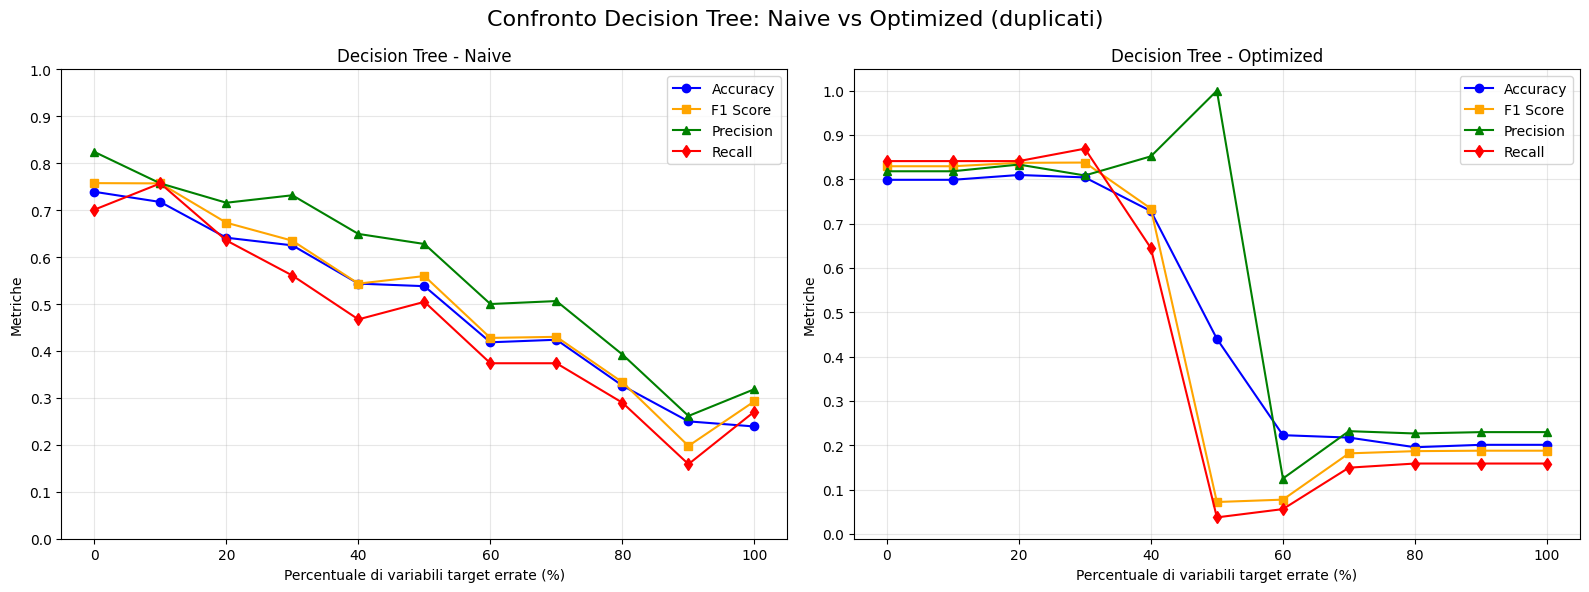

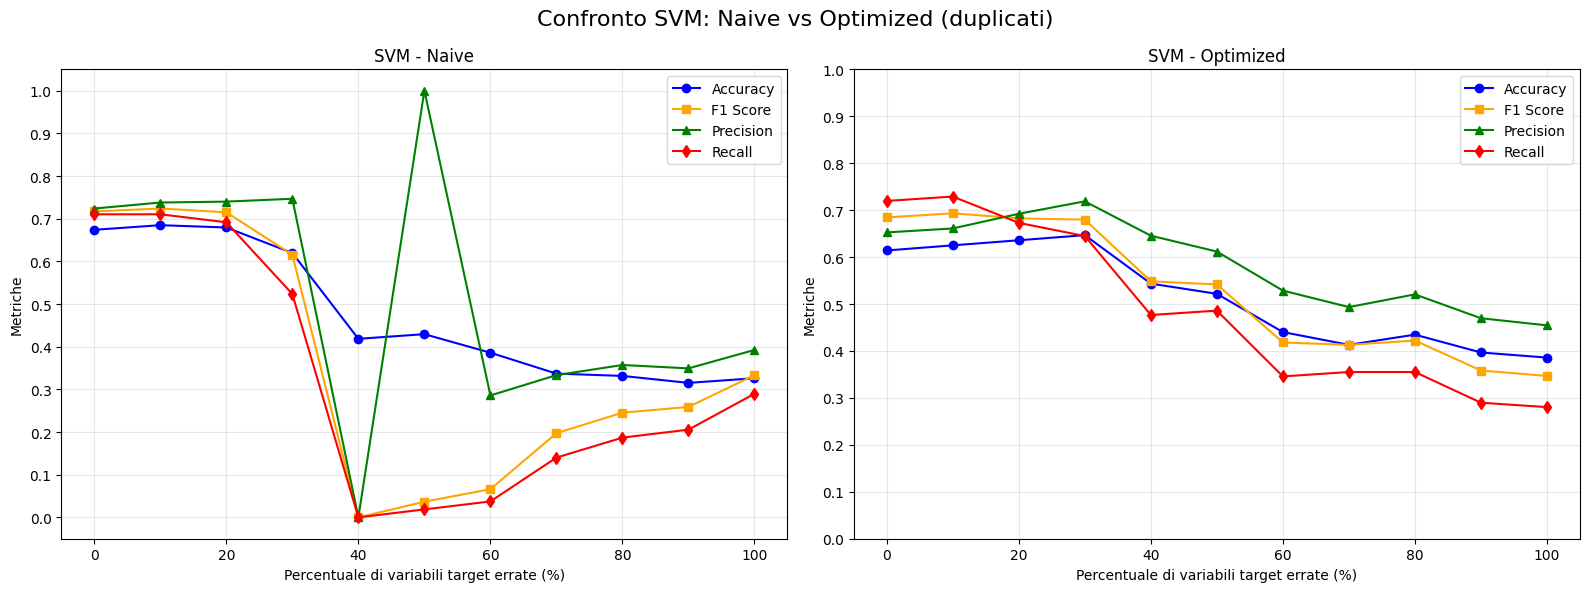

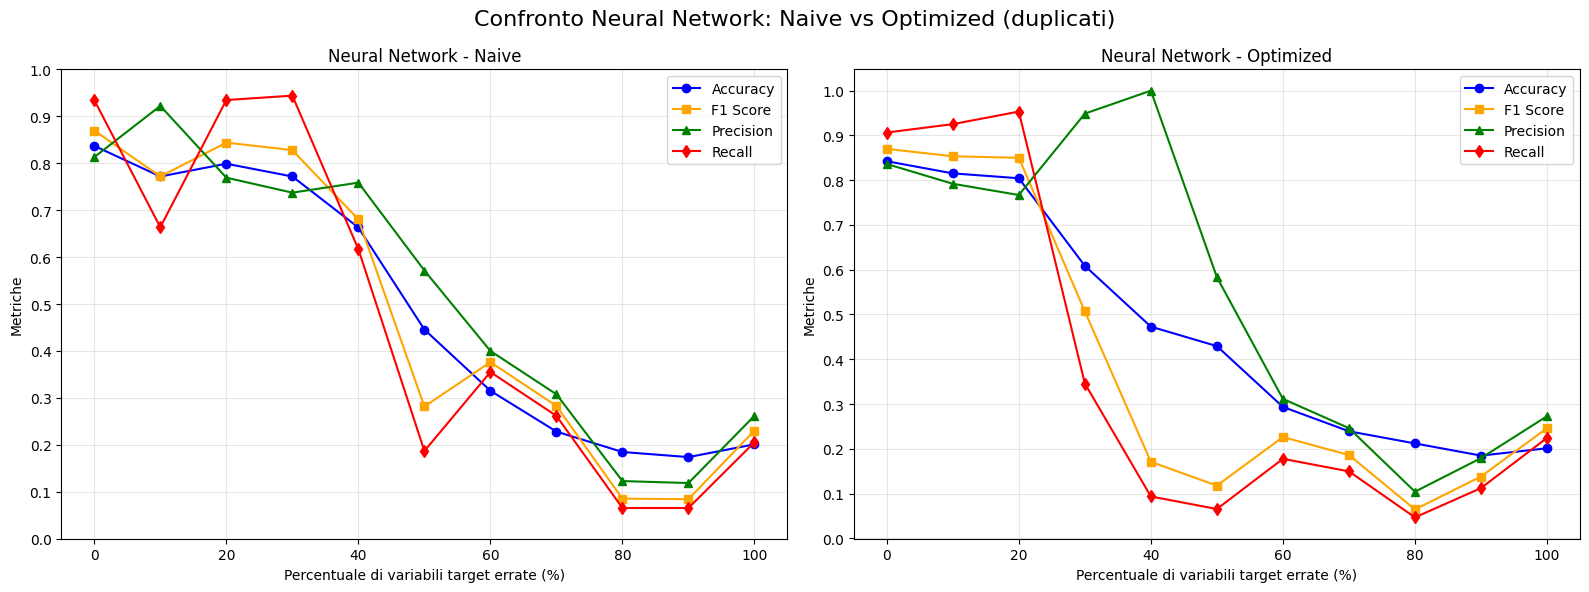

In [118]:
def plot_naive_vs_optimized_duplicates(model_name, original_df):
    """
    Confronta approccio Naive vs Optimized per un modello con dataset contenenti duplicati.
    
    Args:
        model_name: nome del modello da plottare
        duplicated_datasets: lista di DataFrame con duplicati
        original_df: dataset originale pulito
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, approach in enumerate(['Naive', 'Optimized']):
        metrics_df = pd.DataFrame(all_metrics_noisy)
        
        # Filtriamo per modello e approccio
        filtered_df = metrics_df[
            (metrics_df["approach"] == approach) &
            (metrics_df["model"] == model_name)
        ].sort_values("noise_percentage")
        
        if filtered_df.empty:
            print(f"Nessun dato trovato per {model_name} ({approach})")
            continue
        
        # Aggiungiamo il caso pulito (0% duplicati) se non presente
        if not (filtered_df['noise_percentage'] == 0).any():
            clean_row = filtered_df.iloc[0].copy()
            clean_row['noise_percentage'] = 0
            filtered_df = pd.concat([pd.DataFrame([clean_row]), filtered_df], ignore_index=True)
        
        # Plot metriche
        axes[i].plot(filtered_df["noise_percentage"], filtered_df["accuracy"], 
                     marker='o', color='blue', label="Accuracy")
        axes[i].plot(filtered_df["noise_percentage"], filtered_df["f1_score"], 
                     marker='s', color='orange', label="F1 Score")
        axes[i].plot(filtered_df["noise_percentage"], filtered_df["precision"], 
                     marker='^', color='green', label="Precision")
        axes[i].plot(filtered_df["noise_percentage"], filtered_df["recall"], 
                     marker='d', color='red', label="Recall")
        
        axes[i].set_xlabel("Percentuale di variabili target errate (%)")
        axes[i].set_ylabel("Metriche")
        axes[i].set_title(f"{model_name} - {approach}")
        axes[i].set_yticks(np.arange(0, 1.1, 0.1))
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.suptitle(f"Confronto {model_name}: Naive vs Optimized (duplicati)", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_naive_vs_optimized_duplicates('Decision Tree', df)
plot_naive_vs_optimized_duplicates('SVM', df)
plot_naive_vs_optimized_duplicates('Neural Network', df)
